# Visual Vector Search

## 0. Prerequisites
Before we begin, we must install the required libraries.

In [ ]:
!pip install redis img2vec-pytorch

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Install Redis locally (optional)
If you have a Redis db running elsewhere with [Redis Stack](https://redis.io/docs/about/about-stack/) installed, you don't need to run it on this machine. You can skip to the "Connect to Redis server" step.

You can install Redis-Stack locally using the following block:

In [3]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


In [4]:
# Redis connection params
redis_url = "redis://127.0.0.1:6379"

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [29]:
# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

In [5]:
import redis

# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [6]:
# Clear Redis database (optional)
redis_client.flushdb()

True

### Load Working Files from Github

In [7]:
#Load working files from git repository
!npx degit aelkouhen/redis-vss/ColabDrive -f

npx: installed 1 in 2.124s
> destination directory is not empty. Using --force, continuing
> cloned aelkouhen/redis-vss#HEAD


### Mount Google Drive (Optional)

Optionally, you can load the working files from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Vector Storage

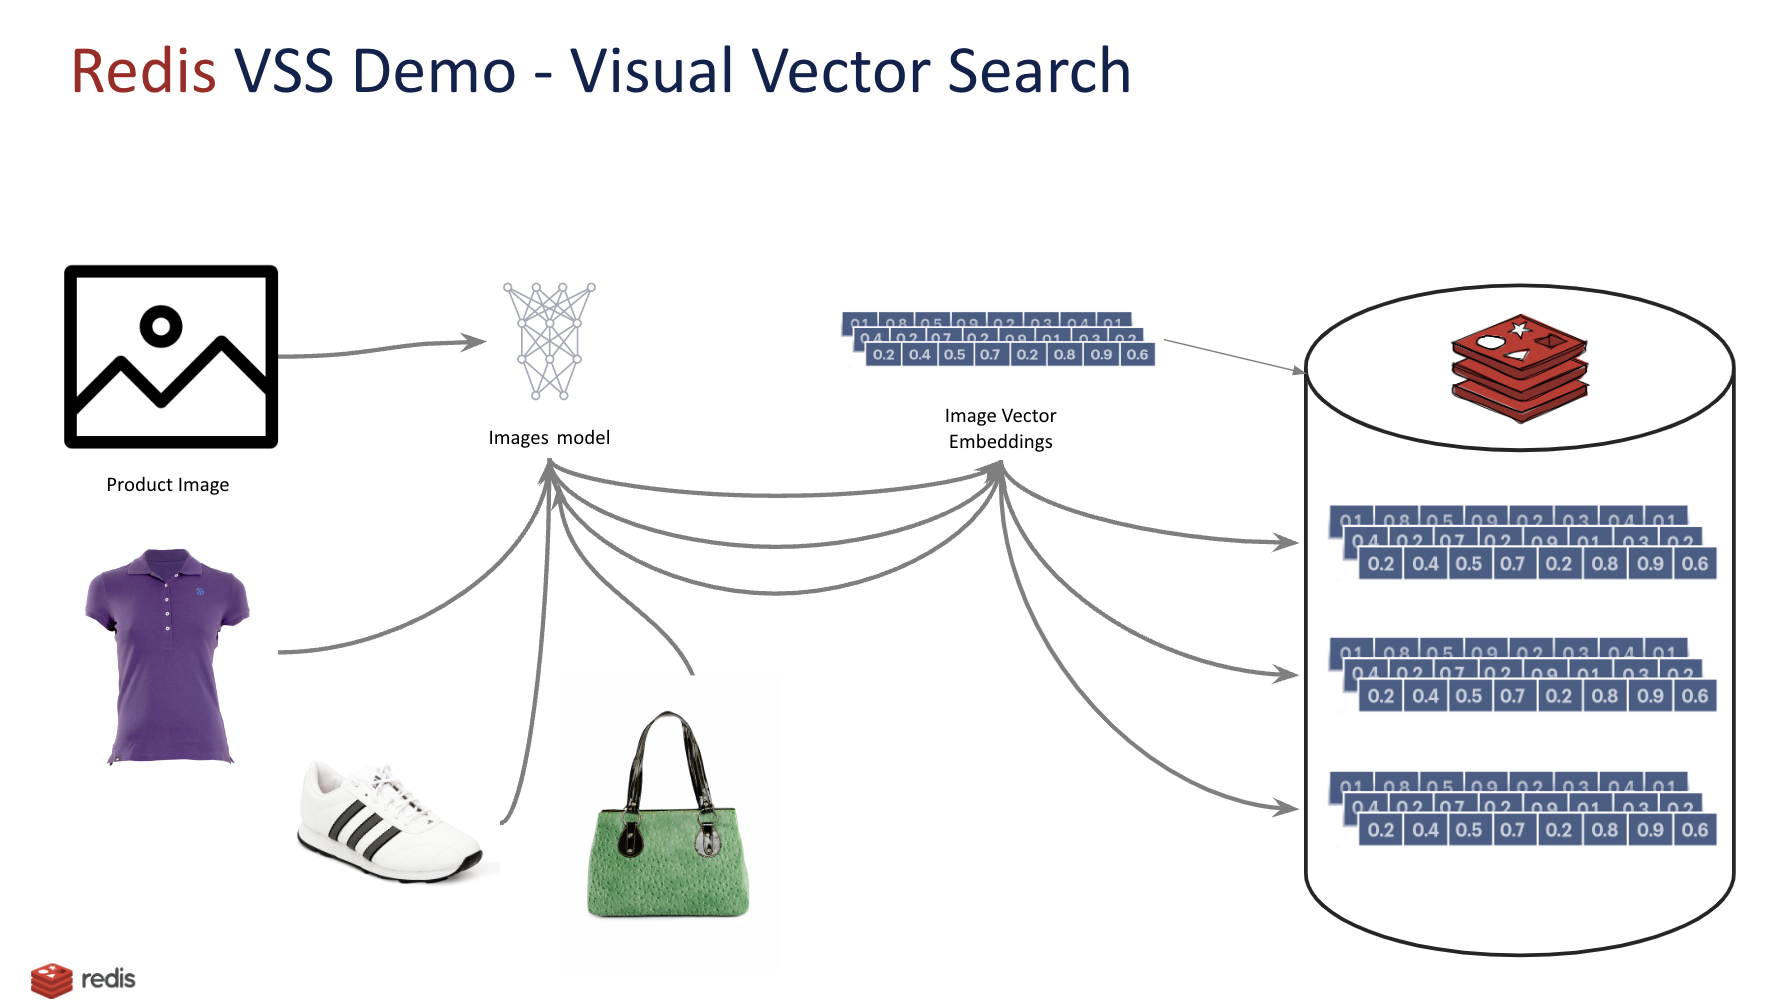

In [8]:
from PIL import Image
from typing import Generator, List, Any
from img2vec_pytorch import Img2Vec
from glob import glob
import matplotlib.pyplot as plt

import os
import redis

# data prep
import pandas as pd
import numpy as np
# for creating image vector embeddings
import urllib.request


def generate_image_vector(file):
   # Resnet-18 to create image embeddings
   image_model = Img2Vec()
   img = Image.open(file).convert('RGB')
   img = img.resize((224, 224))
   return image_model.get_vec(img)

# Convert embeddings to bytes for Redis storage
def convert_embedding(emb: List[float]):
  return np.array(emb).astype(np.float32).tobytes()

# Create Dataframes from image folder
def create_image_dataframe(folder, tag_name, tag):

  myDict = {
      'product_id' : [],
      'product_embedding' : [],
      'product_image_url' : [],
      tag_name : []
  }

  dir = os.path.join(f"{folder}/{tag}", "*.jpg")
  for file in glob(dir):
    id = os.path.splitext(os.path.basename(file))[0]
    myDict['product_id'].append(id)
    myDict['product_embedding'].append(convert_embedding(generate_image_vector(file)))
    myDict[tag_name].append(tag)
    myDict['product_image_url'].append(file)

  df = pd.DataFrame(myDict)
  return df

# display product image
def display_product(file):
  img = Image.open(file).convert('RGB')
  img = img.resize((224, 224))
  plt.imshow(img)
  plt.show()

In [9]:
df_men = create_image_dataframe("products", "gender", "men")
df_women = create_image_dataframe("products", "gender", "women")

df = pd.concat([df_men, df_women])

display(df)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.4MB/s]


,product_id,product_embedding,product_image_url,gender
0,7185ef5d96833937481c19a47edac96a,b'\x10\xa3\xb0?\xc7(\xf4?\xc5[:>;\xf5]:\xc8rQ>...,products/men/7185ef5d96833937481c19a47edac96a.jpg,men
1,393e9315126350d97000721f330aa964,b'h\xc0I@\t\n\x10?\x99Y\x96?}\xe6U=\x07\x80\x1...,products/men/393e9315126350d97000721f330aa964.jpg,men
2,8cf52572340c3592e5f0ede116a0206f,"b'*2C@\x94\x19,?\xe3\xcb\x9a?\xcda\xd1>\x9e\xe...",products/men/8cf52572340c3592e5f0ede116a0206f.jpg,men
3,b3d19377041615d8a7cf46b96ef67c4c,b'BJ\x07@\xa8\t\r@4\xfcB>\xe6\xa8\xec<\xd4\x97...,products/men/b3d19377041615d8a7cf46b96ef67c4c.jpg,men
4,6d62ba4de5c73b36d44f6bff05d2457e,b'\x8dR\x17@;\xd2\x93?\x8f\x98\xa0?i~\xa0=\xc5...,products/men/6d62ba4de5c73b36d44f6bff05d2457e.jpg,men
0,9f70a44e8105afd42debd1302a5149df,b'\x00\xbc\xc0?\xa6\x98\x96?\xe8<\x94>Y\'\x9c<...,products/women/9f70a44e8105afd42debd1302a5149d...,women
1,88046aefb3d87ea8418c12f6f48717fa,b'?5\xa1?\xa3\xdaz?\'\ri>\x0e\x88\x8b?\xea\xe5...,products/women/88046aefb3d87ea8418c12f6f48717f...,women
2,a9d1eabd2f40affad56623f15ad76083,"b'\x88\x0c\xac?\x04,\xd5?\xc1\xd7\xd9>\xcc[\xa...",products/women/a9d1eabd2f40affad56623f15ad7608...,women
3,7ce41800565e35b1c3603642e4b8725f,b'\x9e\xea\xe0?\x03;^?\x1b\xbfM>\xf5\xc2\x17?*...,products/women/7ce41800565e35b1c3603642e4b8725...,women
4,ec28a6e80636805d0bf993699b656c88,b'\x1f\xa9\xee?\x9d\'\xf9>\x9a\xd0j?s\xa7\xc1=...,products/women/ec28a6e80636805d0bf993699b656c8...,women


In [10]:
for index, row in df.iterrows():
  redis_client.hset(f"product:{row['product_id']}", mapping={"product_id": row['product_id'], "product_embedding": row['product_embedding'], "product_image_url": row["product_image_url"], "gender": row['gender']})

## 2. Vector Indexing
After creating embeddings that represent the products and storing them in Redis, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, [check out these docs](https://redis.io/docs/interact/search-and-query/search/vectors/) and [these Redis AI resources](https://github.com/RedisVentures/redis-ai-resources).


In [11]:
from redis.commands.search.field import (
    TagField,
    VectorField,
)

from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

# Function to create a FLAT search index with Redis/RediSearch
def create_flat_index(
    redis_conn,
    vector_field_name: str,
    number_of_vectors: int,
    index_name:str,
    prefix: str,
    distance_metric: str='COSINE'
):
    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    image_field = VectorField(f"{vector_field_name}", "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": 512,
                    "DISTANCE_METRIC": distance_metric,
                    "INITIAL_CAP": number_of_vectors
                })

    redis_conn.ft(index_name).create_index(
        fields = [image_field],
        definition = IndexDefinition(prefix=[prefix], index_type=IndexType.HASH)
    )

In [12]:
# Create an FLAT search index for the products created earlier.
create_flat_index(redis_client, "product_embedding", 3, "product_index",'product:')

Creating new index


## 3. Vector Querying
Let's choose a product's image (query image) and calculate its distance (similarity) with the product created previously.

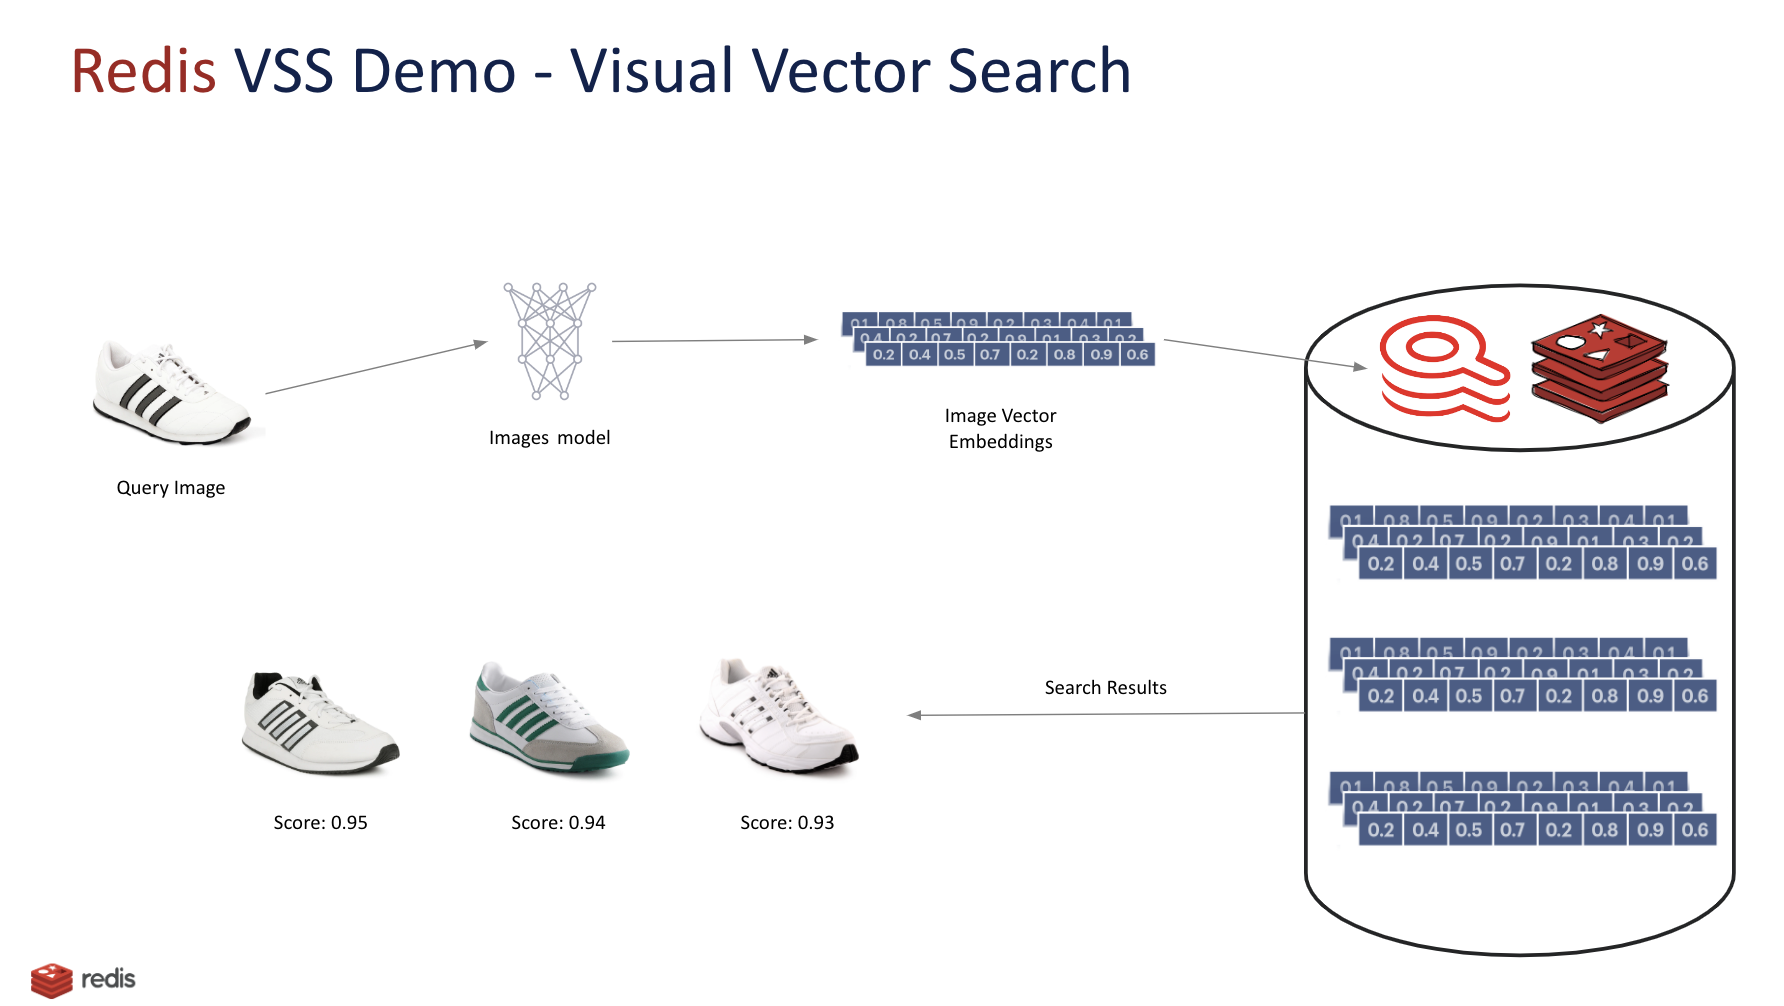

In [13]:
# 1. Create query vector
query_image = "products/input/2eca615a43d0098f4bb5fc90004c3678.jpg"

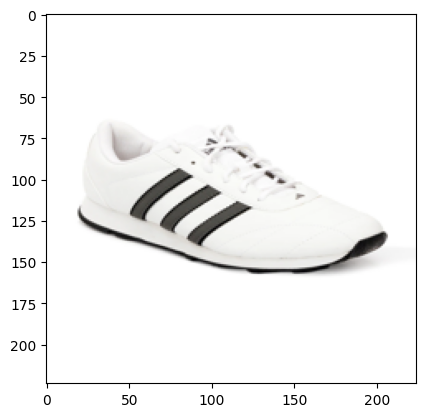

In [14]:
display_product(query_image)

### Define a helper function to perform the KNN similarity search

We define a helper function, `similarity_search`, to create an embedding from the query image and compare it to other vectors having the same prefix according to the index created previously.

In [15]:
from redis.commands.search.query import Query
import pandas as pd

# Helper method to perform KNN similarity search in Redis
def similarity_search(query_image: str, k: int, return_fields: tuple, index_name: str = "product_index") -> list:
    # create redis query object
    redis_query = (
        Query(f"*=>[KNN {k} @product_embedding $product_embedding AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = generate_image_vector(query_image)

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"product_embedding": convert_embedding(query_vector)}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"])

In [16]:
# 2. Perform vector similarity search with given query
results = similarity_search(query_image, k=3, return_fields=("distance", "product_image_url",	"product_id", "gender"))
results['score'] = 1 - results['distance'].astype('float64')
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))


,id,product_image_url,product_id,gender,score
0,product:393e9315126350d97000721f330aa964,products/men/393e9315126350d97000721f330aa964.jpg,393e9315126350d97000721f330aa964,men,0.954971
1,product:8cf52572340c3592e5f0ede116a0206f,products/men/8cf52572340c3592e5f0ede116a0206f.jpg,8cf52572340c3592e5f0ede116a0206f,men,0.942790
2,product:6d62ba4de5c73b36d44f6bff05d2457e,products/men/6d62ba4de5c73b36d44f6bff05d2457e.jpg,6d62ba4de5c73b36d44f6bff05d2457e,men,0.933378


Product 393e9315126350d97000721f330aa964 - Gender men - Score 0.9549709558487


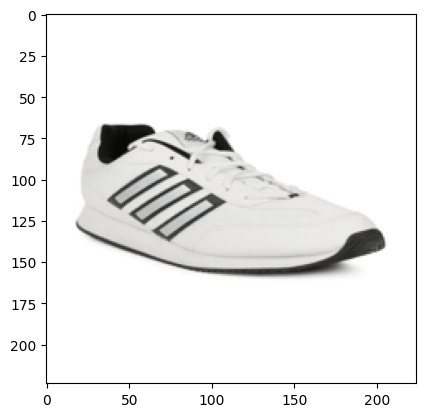

Product 8cf52572340c3592e5f0ede116a0206f - Gender men - Score 0.942790210247


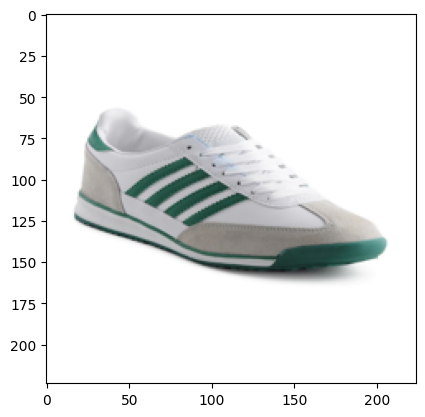

Product 6d62ba4de5c73b36d44f6bff05d2457e - Gender men - Score 0.9333783388138


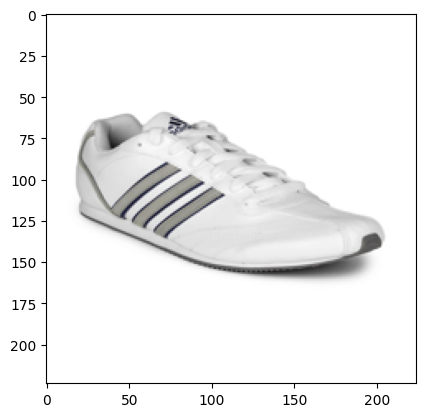

In [18]:
for index, row in results.iterrows():
  print(f"Product {row['product_id']} - Gender {row['gender']} - Score {row['score']}")
  display_product(row['product_image_url'])